In [8]:
import numpy as np
import matplotlib.pyplot as plt
import math
import random
from mpl_toolkits.mplot3d import axes3d


Optimised Growth:  0.15014697450345552
Optimised f1:  43
Optimised f2:  68


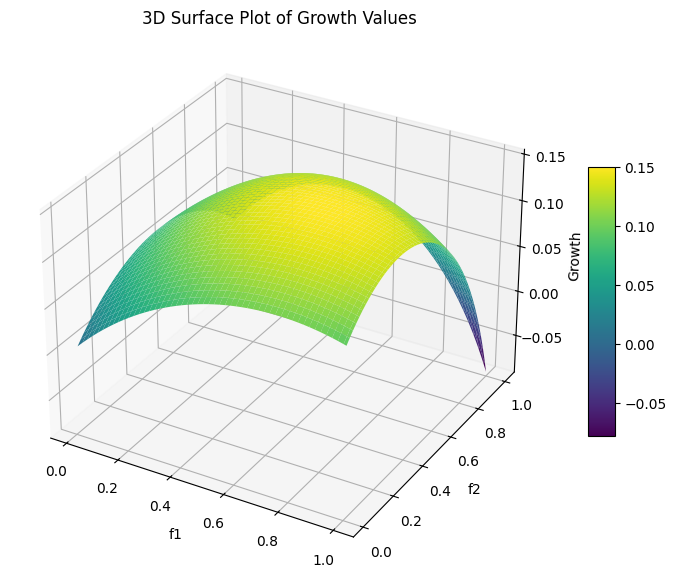

In [9]:
# Coin 1 flip : It will return a number between 1 and 100
# We let H for Coin 1 be a win and T a loss, and give a value for P(H) and P(T).
def flip1(p1):
    return 'H' if random.random() < p1 else 'T'


# Coin 2 flip : It will return a number between 1 and 100
# We let H for Coin 2 be a loss and T a win, and give a value for P(H) and P(T).
def flip2(p2):
    return 'H' if random.random() < p2 else 'T'


# This function simulates a play of the game 
# we flip the 2 coins, getting an outcome for each, and return both outcomes
def playGame(p1, p2):
    result1 = flip1(p1)
    result2 = flip2(p2)
    
    outcome = [result1, result2]
    
    return outcome

# We calculate the new value of wealth generated from playing the game
# We wager a proportion of our wealth based on f1 and f2
# We then get a return on the wagers based on the outcomes of each game
# We then return the sum of our remaining assets and add the new value of the assets we put in the game
def NewValueOfWealth(f1, f2, wealth):
    wager1 = wealth * f1
    wager2 = wealth * f2

    outcome = playGame(p1,p2)
    
    if outcome[0] == 'H':
        wager1 += k1_H*wager1
    else:
        wager1 += k1_T*wager1
        
    if outcome[1] == 'T':
        wager2 += k2_H*wager2
    else:
        wager2 += k2_T*wager2
    
    return wealth*(1 - f1 - f2) + wager1 + wager2


# We define the variables for our program
V0 = 1000  # initial wealth
plays_of_game = 250  # we will play the game 100 times (100 coin flips)
num_runs = 100  # We will repeat the simulation of playing the game 100 times 1000 times to get our average growth rate


p1 = 0.5  # P(H) for coin 1
q1 = 1 - p1  # P(T) for coin 1

p2 = 0.5  # P(H) for coin 2
q2 = 1 - p2  # P(T) for coin 2

k1_H = 1  # Return on coin 1 given H
k1_T = -0.4  # Return on coin 1 given T
k2_H = -0.5  # Return on coin 2 given H
k2_T = 1  # Return on coin 2 given T

# This function gets the average growth of our model by running multiple iterations of the game (where in each iteration we play the game N times)
def getAverageGrowth(f1,f2):
    growth_rate = 0  # This will determine the average growth rate for a given investment fraction f = (f1,f2)
    
    for i in range(num_runs):
        wealth = [V0]
        
        # We do an iteration where we play the game a number of times and extract our wealth value at the end of the game
        for i in range(1,plays_of_game):
            wealth.append(NewValueOfWealth(f1,f2, wealth[-1]))
        
        # We use our growth formula as defined in the notes    
        growth_rate += 1/plays_of_game * np.log(wealth[-1]/wealth[0])
    
    # After we have taken up a number of samples, we take an average of all the growth rates obtained
    average_growth = growth_rate/num_runs 
    return average_growth


# We build the 2D mesh of different values we can give to f1 and f2
fraction_list = np.arange(0.01, 1.01, 0.01)
F1, F2 = np.meshgrid(fraction_list, fraction_list)

# This function returns the average growth from the function above
def growth(x,y):    
    return getAverageGrowth(x,y)


# We plot our results below, with (f1, f2) as the x-y plane, and the growth on the z-axis
growth_values = growth(F1, F2)
print("Optimised Growth: ", np.max(growth_values))
max_index = np.unravel_index(np.argmax(growth_values), growth_values.shape)
print("Optimised f1: ", max_index[0])
print("Optimised f2: ", max_index[1])

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111,projection='3d')
surface = ax.plot_surface(F1,F2, growth_values, cmap="viridis")

ax.set_xlabel('f1')
ax.set_ylabel('f2')
ax.set_zlabel('Growth')

fig.colorbar(surface, shrink=0.5, aspect=10)

plt.title("3D Surface Plot of Growth Values")
plt.show()


Optimised Growth 0.15203451850981017
Optimised f1 0.7001044796321388
Optimised f2 0.4358881835824517


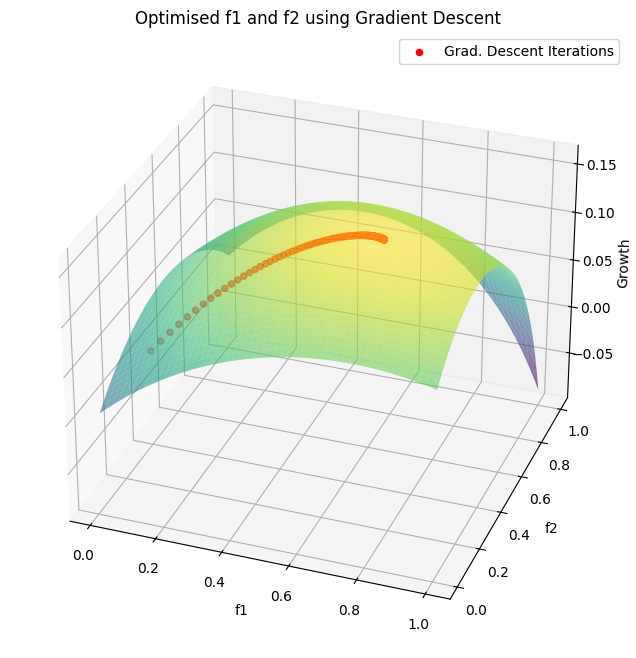

In [16]:
# Assuming that N is sufficiently large such that we can remove the limit from the formula, this is the analytical formula for the Growth Function in the 2 coin game
def growth_function(f1, f2):
    return ( p1*p2*np.log(1 + f1*k1_H + f2*k2_H) + p1*q2*np.log(1 + f1*k1_H + f2*k2_T) + p2*q1*np.log(1 + f1*k1_T + f2*k2_H) + p2*q2*np.log(1 + f1*k1_T + f2*k2_T) )

# The following two functions are the partial derivatives of the Growth function
def dG_df1(f1, f2):
    return ( k1_H*p1*p2*1/(1 + f1*k1_H + f2*k2_H) + k1_H*p1*q2*1/(1 + f1*k1_H + f2*k2_T) + k1_T*p2*q1*1/(1 + f1*k1_T + f2*k2_H) + k1_T*p2*q2*1/(1 + f1*k1_T + f2*k2_T) )

def dG_df2(f1, f2):
    return ( k2_H*p1*p2*1/(1 + f1*k1_H + f2*k2_H) + k2_T*p1*q2*1/(1 + f1*k1_H + f2*k2_T) + k2_H*p2*q1*1/(1 + f1*k1_T + f2*k2_H) + k2_T*p2*q2*1/(1 + f1*k1_T + f2*k2_T) )

# We define our gradient descent algorithm, which aims to find the max. of the growth function
def gradient_descent(start_f1, start_f2, learning_rate, num_iterations):
    
    # We start with initial guesses for f1 and f2
    f1 = start_f1
    f2 = start_f2
    history = []
    
    # For each iteration, we get the value of the partial derivatives given our guess.
    # We use these values to subtract from our initial guess times some learning rate for stability
    # Note: ONce we hit the max, the partial derivatives will be 0, meaning the values for f1 and f2 won't change!
    for i in range(num_iterations):
        grad_f1 = dG_df1(f1,f2)
        grad_f2 = dG_df2(f1,f2)
        
        f1 = f1 + learning_rate * grad_f1
        f2 = f2 + learning_rate * grad_f2
        
        history.append((f1, f2, growth_function(f1, f2)))
    
    return f1, f2, growth_function(f1, f2), history


fraction_list = np.arange(0.01, 1.01, 0.01)
F1, F2 = np.meshgrid(fraction_list, fraction_list)
G = growth_function(F1, F2)

# We define our initial guesses and the learning rate
start_f1 = 0.1
start_f2 = 0.1
learning_rate = 0.1
num_iterations = 500
f1_optimised, f2_optimised, G_optimised, history = gradient_descent(start_f1, start_f2, learning_rate, num_iterations)

print("Optimised Growth", G_optimised)
print("Optimised f1", f1_optimised)
print("Optimised f2", f2_optimised)


# We plot our results below, alongside the process of optimising the values for f1 and f2 through Gradient Descent
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111,projection='3d')
surface = ax.plot_surface(F1,F2, G, cmap="viridis", alpha=0.6)
ax.scatter(*zip(*history), c='r', marker='o', label="Grad. Descent Iterations")
ax.set_xlabel('f1')
ax.set_ylabel('f2')
ax.set_zlabel('Growth')
ax.view_init(elev=30, azim=290)  # Change the viewing angle
ax.legend()

plt.title("Optimised f1 and f2 using Gradient Descent")
plt.show()
